In [1]:
import numpy as np
import matplotlib.pyplot as plt

## **Generate configurations**

In [2]:
def generate_configurations(N, filename, fixed_ends=None, rate=10000):
    """
    Generate Ising model configurations and save to a file.

    Parameters:
    - N (int): Number of spins.
    - filename (str): Output file to save configurations.
    - fixed_ends (tuple): Optional (left_spin, right_spin), e.g., (1, 1). Use None for open BC.
    - rate (int): Save to file in batches of this size.
    """
    from itertools import product

    def is_valid(config):
        if fixed_ends:
            left, right = fixed_ends
            return config[0] == left and config[-1] == right
        return True

    with open(filename, "w") as f:
        counter = 0
        to_save = []
        for config in product([-1, 1], repeat=N):
            if not is_valid(config):
                continue
            to_save.append(config)
            counter += 1
            if counter % rate =09fgrt= 0:
                for line in to_save:
                    f.write(" ".join(map(str, line)) + "\n")
                print(f"Saved {counter} configurations")
                to_save = []
        for line in to_save:
            f.write(" ".join(map(str, line)) + "\n")
        print(f"Done! Total saved: {counter}")


In [3]:
# Open boundary (no fixed spins)
open_boundary = generate_configurations(N=10, filename="config_open.dat")

# Fixed boundary (first and last spin = 1)
fixed_boundary_1_1 = generate_configurations(N=10, filename="config_fixed_1_1.dat", fixed_ends=(1, 1))

# Fixed boundary (first spin = -1 and last spin = 1)
fixed_boundary_neg1_1 = generate_configurations(N=10, filename="config_fixed_neg1_1.dat", fixed_ends=(-1, 1))



Done! Total saved: 1024
Done! Total saved: 256
Done! Total saved: 256


## **Functions for computational approach**

In [4]:
# Reading
def read_config(config):
    return [2*int(spin) - 1 for spin in config.split(" ")]

# Computational appraoch

def energy(config, boundary="periodic", left_spin=1, right_spin=1):
    """
    Compute the energy of a 1D spin configuration.

    Parameters:
        config (list or array): The spin configuration (e.g., [+1, -1, +1, ...])
        boundary (str): Type of boundary condition:
                        "periodic", "open", or "fixed"
        left_spin (int): Fixed spin value at the left end (used if boundary="fixed")
        right_spin (int): Fixed spin value at the right end (used if boundary="fixed")

    Returns:
        float: Energy of the configuration (in units of J)
    """
    result = 0
    for i in range(len(config) - 1):
        result += config[i] * config[i + 1]
    
    if boundary == "periodic":
        result += config[-1] * config[0]
    elif boundary == "fixed":
        result += left_spin * config[0]      # Left boundary
        result += config[-1] * right_spin    # Right boundary
    elif boundary != "open":
        raise ValueError(f"Unknown boundary condition: {boundary}")

    return -result

    
def rel_probability(config, K, boundary="periodic", left_spin=1, right_spin=1):
    return np.exp(- K * energy(config, boundary=boundary, 
                               left_spin=left_spin, right_spin=right_spin))

def one_point(config, boundary="periodic"):
    config = np.array(config)
    if boundary == "periodic":
        return np.mean(config)
    elif boundary in ["open", "fixed"]:
        return config  # or np.array(config) to emphasize it's positional
    else:
        raise ValueError(f"Unknown boundary condition: {boundary}")


def two_point(config, boundary="periodic", left_spin=1, right_spin=1):
    config = np.array(config)
    N = len(config)
    result = []

    if boundary == "periodic":
        for d in range(N):
            result.append(np.mean(config * np.roll(config, d)))

    elif boundary == "open":
        for d in range(N):
            if N - d > 0:
                vals = [config[i] * config[i + d] for i in range(N - d)]
                result.append(np.mean(vals))
            else:
                result.append(np.nan)  # Optional: fill with NaN beyond limits

    elif boundary == "fixed":
        # Pad config with fixed spins
        padded = np.concatenate([[left_spin], config, [right_spin]])
        for d in range(N):
            vals = []
            for i in range(1, N - d + 1):  # Avoid indexing into fixed padding
                vals.append(padded[i] * padded[i + d])
            result.append(np.mean(vals))
    else:
        raise ValueError(f"Unknown boundary condition: {boundary}")

    return np.array(result)


## **Ising Model functoin**

In [5]:
# Function to return appropriate energy and two-point functions based on boundary condition

def get_ising_functions(boundary, left_spin=1, right_spin=1):
    if boundary == "periodic":
        def energy_fn(config): return energy(config, boundary="periodic")
        def two_point_fn(config): return two_point(config, boundary="periodic")
        analytic_Z = partition_function_analytic_periodic
    elif boundary == "open":
        def energy_fn(config): return energy(config, boundary="open")
        def two_point_fn(config): return two_point(config, boundary="open")
        analytic_Z = partition_function_analytic_open
    elif boundary == "fixed":
        def energy_fn(config): return energy(config, boundary="fixed", left_spin=left_spin, right_spin=right_spin)
        def two_point_fn(config): return two_point(config, boundary="fixed", left_spin=left_spin, right_spin=right_spin)
        analytic_Z = partition_function_analytic_fixed
    else:
        raise ValueError(f"Unknown boundary condition: {boundary}")

    def rel_probability_fn(config, K):
        return np.exp(-K * energy_fn(config))

    return {
        "energy": energy_fn,
        "two_point": two_point_fn,
        "rel_probability": rel_probability_fn,
        "partition_function_analytic": analytic_Z
    }


## **Analytic Results Functions**

In [6]:
def partition_function_analytic_open(K, N):
    cosh2 = 2 * np.cosh(K)
    return (cosh2) ** (N)

def partition_function_analytic_fixed(K, N, left_spin=1, right_spin=1):

    cosh2 = 2 * np.cosh(K)
    sinh2 = 2 * np.sinh(K)
    
    boundary_product = left_spin * right_spin  # +1 or -1

    return (cosh2)**N + boundary_product * (sinh2)**N

def two_point_analytic_fixed(i, j, K, N, left_spin=1, right_spin=1):
    """
    Analytic two-point correlation function ⟨σᵢ σⱼ⟩ for fixed boundary Ising model.

    Parameters:
    i, j: spin indices (0-based, i ≤ j recommended)
    K: coupling constant
    N: number of spins
    left_spin, right_spin: ±1 for fixed boundaries

    Returns:
    float: analytic two-point correlation ⟨σᵢ σⱼ⟩
    """
    cosh2 = 2 * np.cosh(K)
    sinh2 = 2 * np.sinh(K)

    # Use the symmetry that +1,+1 and -1,-1 give same result (symmetric), 
    # and +1,-1 or -1,+1 give opposite-sign (antisymmetric) combination
    sign = 1 if left_spin * right_spin == 1 else -1

    term1 = (cosh2)**(N - max(i, j)) * (sinh2)**abs(j - i) * (cosh2)**min(i, j)
    term2 = (sinh2)**(N - max(i,j)) * (cosh2)**abs(j - i) * (sinh2)**min(i, j)
    numerator = term1 + sign * term2

    Z = partition_function_analytic_fixed(K, N, left_spin, right_spin)

    return numerator / Z

def two_point_analytic_open(i, j, K, N):
    cosh2 = 2 * np.cosh(K)
    sinh2 = 2 * np.sinh(K)

    numerator = (cosh2) ** (N - max(i, j)) * (sinh2) ** abs(j - i) * (cosh2) ** min(i, j)
    return numerator / partition_function_analytic_open(K, N)

    




## **Partition function computional**

In [7]:
def partition_function(
    configs_file,
    K_min,
    K_max,
    output_file,
    n_K=100,
    boundary="periodic",
    left_spin=1,
    right_spin=1
):
    """
    Computes the partition function numerically by summing over configurations
    for a range of coupling constants K, and optionally saves to file.

    Parameters:
    - configs_file: str, path to the file with all configurations
    - K_min: float, minimum K value
    - K_max: float, maximum K value
    - output_file: str, path to write output
    - n_K: int, number of K points between K_min and K_max
    - boundary: str, "periodic", "open", or "fixed"
    - left_spin: int, left boundary spin for "fixed" condition (±1)
    - right_spin: int, right boundary spin for "fixed" condition (±1)

    Returns:
    - Ks: list of K values
    - Zs: list of partition function values
    - N: number of spins in the configuration
    """

    # Load configurations
    configs = np.loadtxt(configs_file, dtype=int)
    N = configs.shape[1]  # number of spins per config

    # Get appropriate energy function
    funcs = get_ising_functions(boundary, left_spin=left_spin, right_spin=right_spin)
    energy_fn = funcs["energy"]

    Ks = np.linspace(K_min, K_max, n_K)
    Zs = []

    for K in Ks:
        Z = 0.0
        for config in configs:
            Z += np.exp(-K * energy_fn(config))
        Zs.append(Z)

    # Write to file
    with open(output_file, "w") as f:
        f.write(f"{N}\n")
        for K_val, Z_val in zip(Ks, Zs):
            f.write(f"{K_val:.10f} {Z_val:.10f}\n")

    return Ks, Zs, N


## **Function to plot parition function**

In [8]:
def plot_partition_function(
    Zs_file,
    boundary="periodic",
    show_plot=True,
    save_path=None,
    title="Partition Function",
    latex=True,
    left_spin=1,
    right_spin=1
):
    """
    Plots the partition function from file and optionally includes the analytic result.
    """
    if latex:
        plt.rcParams["text.usetex"] = True
        plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"

    Ks, Zs, Zs_analytic = [], [], []

    # Get functions from boundary-aware setup
    funcs = get_ising_functions(boundary, left_spin, right_spin)
    analytic_Z_fn = funcs["partition_function_analytic"]

    # Load file
    with open(Zs_file, "r") as f:
        N = int(float(f.readline().strip()))
        for line in f:
            K_str, Z_str = line.strip().split()
            K, Z = float(K_str), float(Z_str)
            Ks.append(K)
            Zs.append(Z)
            Zs_analytic.append(analytic_Z_fn(K, N))

    # Plot
    fig, ax = plt.subplots()
    ax.plot(Ks, Zs, label="Numerical", color="tab:blue")
    ax.plot(Ks, Zs_analytic, lw=3, alpha=0.5, label="Analytic", color="tab:orange")

    ax.set_xlabel(r"$K$")
    ax.set_ylabel(r"$Z$")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path)
        print(f"Saved plot to {save_path}")
    if show_plot:
        plt.show()

    return fig, ax



## **Plot of Partition Function for Open BC**

In [9]:
Ks, Zs, N = partition_function(
    configs_file="config_open.dat",
    K_min=0.1,
    K_max=0.7,
    output_file="Zs_open.dat",
    n_K=100,
    boundary="open"
)


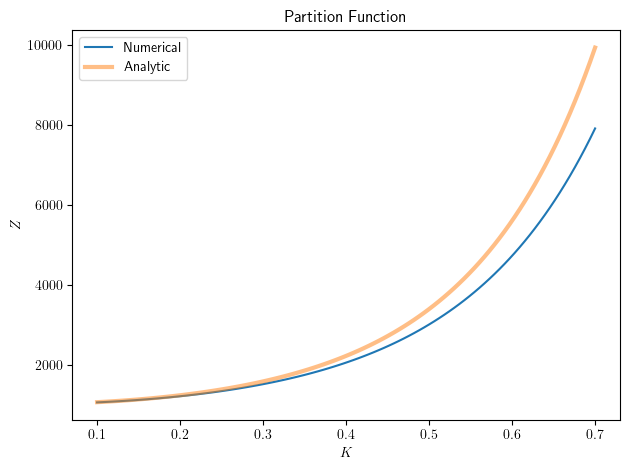

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Partition Function'}, xlabel='$K$', ylabel='$Z$'>)

In [10]:
# Plotting the parition function for open bc
plot_partition_function("Zs_open.dat", boundary="open")

## **Plott Partition Functoin for Fixed BC at +1+1**

In [11]:
Ks, Zs, N = partition_function(
    configs_file="config_fixed_1_1.dat",
    K_min=0.1,
    K_max=0.7,
    output_file="Zs_fixed_1_1.dat",
    n_K=100,
    boundary="fixed",
    left_spin=1,
    right_spin=1
)

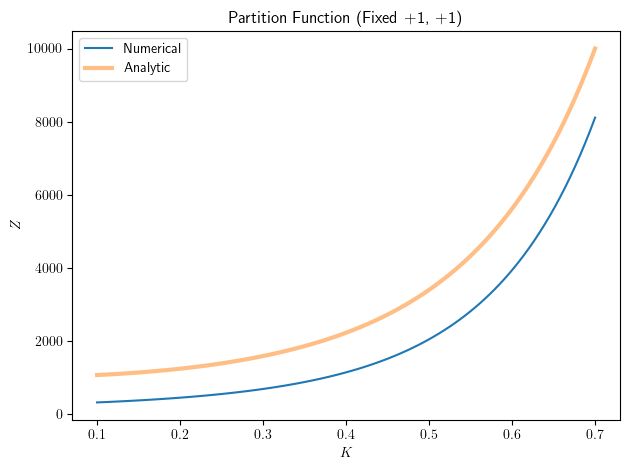

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Partition Function (Fixed +1, +1)'}, xlabel='$K$', ylabel='$Z$'>)

In [12]:
plot_partition_function(
    Zs_file="Zs_fixed_1_1.dat",
    boundary="fixed",
    left_spin=1,
    right_spin=1,
    title="Partition Function (Fixed +1, +1)"
)

## **Plotting Partition Function for Fixed BC at -1+1**

In [13]:
Ks, Zs, N = partition_function(
    configs_file="config_fixed_neg1_1.dat",
    K_min=0.1,
    K_max=0.7,
    output_file="Zs_fixed_neg1_1.dat",
    n_K=100,
    boundary="fixed",
    left_spin=-1,
    right_spin=1
)

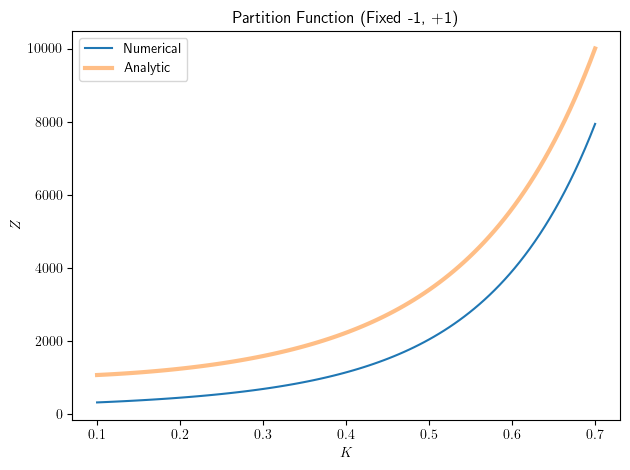

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Partition Function (Fixed -1, +1)'}, xlabel='$K$', ylabel='$Z$'>)

In [14]:
plot_partition_function(
    Zs_file="Zs_fixed_neg1_1.dat",
    boundary="fixed",
    left_spin=-1,
    right_spin=1,
    title="Partition Function (Fixed -1, +1)"
)

## **Function to plot the two point correlation**

In [15]:
def plot_two_point_correlation_v1(config_file, K, boundary="fixed", 
                                     left_spin=1, right_spin=1):
    """
    Plot ⟨σᵢσⱼ⟩ vs i for both computational and analytic approaches.

    Parameters:
    config_file (str): Path to file with spin configurations.
    K (float): Coupling constant.
    boundary (str): "fixed" or "open".
    left_spin (int): Fixed left boundary spin (if applicable).
    right_spin (int): Fixed right boundary spin (if applicable).
    """
    # Load all configurations from file
    with open(config_file, "r") as f:
        configs = [list(map(int, line.strip().split())) for line in f]

    N = len(configs[0])
    j = 0  # Fixed index j

    # Get relevant functions
    funcs = get_ising_functions(boundary, left_spin, right_spin)

    # --- Computational approach ---
    Z = 0.0
    empirical_corr = np.zeros(N)
    for config in configs:
        weight = funcs["rel_probability"](config, K)
        Z += weight
        for i in range(N):
            empirical_corr[i] += weight * config[i] * config[j]
    empirical_corr /= Z

    # --- Analytic approach ---
    analytic_corr = []
    for i in range(N):
        if boundary == "fixed":
            val = two_point_analytic_fixed(i, j, K, N)
        elif boundary == "open":
            val = two_point_analytic_open(i, j, K, N)
        else:
            raise ValueError(f"Unsupported boundary: {boundary}")
        analytic_corr.append(val)
    analytic_corr = np.array(analytic_corr)

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.scatter(range(N), empirical_corr, label="Computational", color='blue')
    plt.plot(range(N), analytic_corr, label="Analytic", color='orange')
    plt.xlabel("Spin index $i$")
    plt.ylabel(r"$\langle \sigma_i \sigma_j \rangle$")
    plt.title(f"Two-point correlation (boundary={boundary}, j={j}, K={K})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_two_point_correlation_v2(config_file, K, boundary="fixed",
                               left_spin=1, right_spin=1):
    """
    Plot ⟨σ_i σ_j⟩ vs i for both computational and analytic approaches.
    """
    # Load configurations
    with open(config_file, "r") as f:
        configs = [list(map(int, line.strip().split())) for line in f]

    N = len(configs[0])
    j = 0  # Fixed reference index

    funcs = get_ising_functions(boundary, left_spin, right_spin)

    # --- Computational approach ---
    Z = 0.0
    empirical_corr = np.zeros(N)
    for config in configs:
        weight = funcs["rel_probability"](config, K)
        Z += weight
        for i in range(N):
            empirical_corr[i] += weight * config[i] * config[j]
    empirical_corr /= Z

    # --- Analytic approach ---
    analytic_corr = []
    for i in range(N):
        if boundary == "fixed":
            val = two_point_analytic_fixed(i + 1, j + 1, K, N, left_spin, right_spin)
        elif boundary == "open":
            val = two_point_analytic_open(i + 1, j + 1, K, N)
        else:
            raise ValueError(f"Unsupported boundary: {boundary}")
        analytic_corr.append(val)
    analytic_corr = np.array(analytic_corr)

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.scatter(range(N), empirical_corr, label="Computational", color='blue')
    plt.plot(range(N), analytic_corr, label="Analytic", color='orange')
    plt.xlabel("Spin index $i$")
    plt.ylabel(r"$\langle \sigma_i \sigma_j \rangle$")
    plt.title(f"Two-point correlation (boundary={boundary}, j={j}, K={K})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## **Plot of correlation for Open BC**

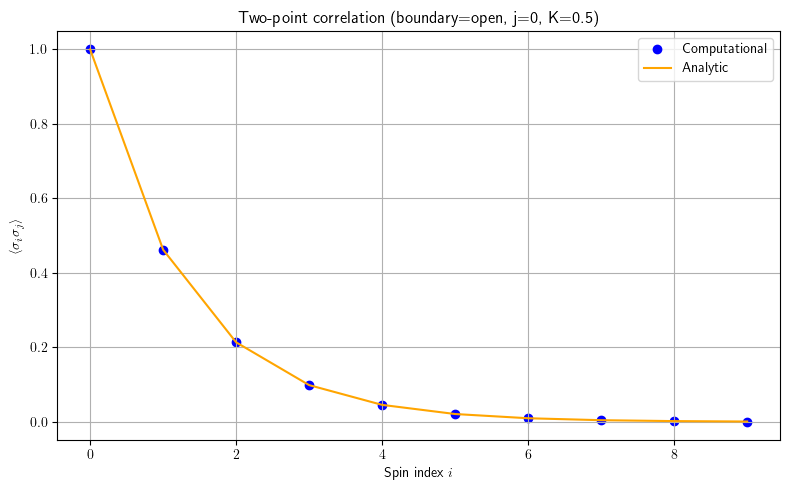

In [17]:
plot_two_point_correlation_v2(
    config_file="config_open.dat",
    K=0.5,
    boundary="open",
)

## **Plot of correlation for Fixed BC at -1+1**

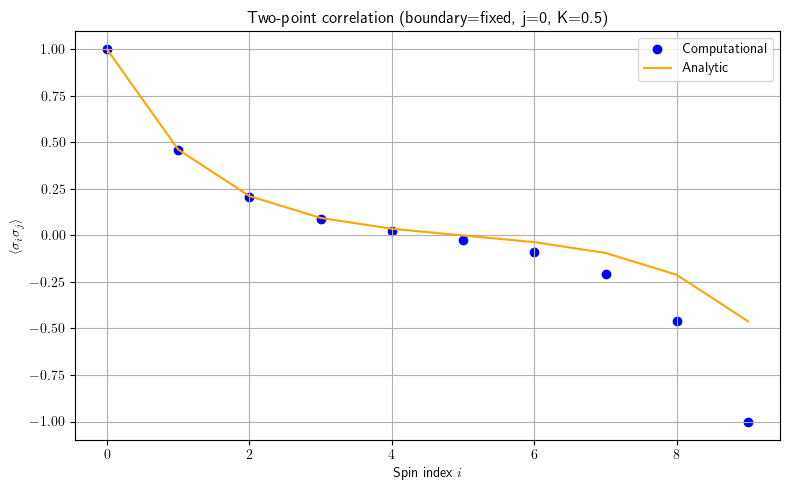

In [18]:
plot_two_point_correlation_v2(
    config_file="config_fixed_neg1_1.dat",
    K=0.5,
    boundary="fixed",
    left_spin=-1,
    right_spin=1
)

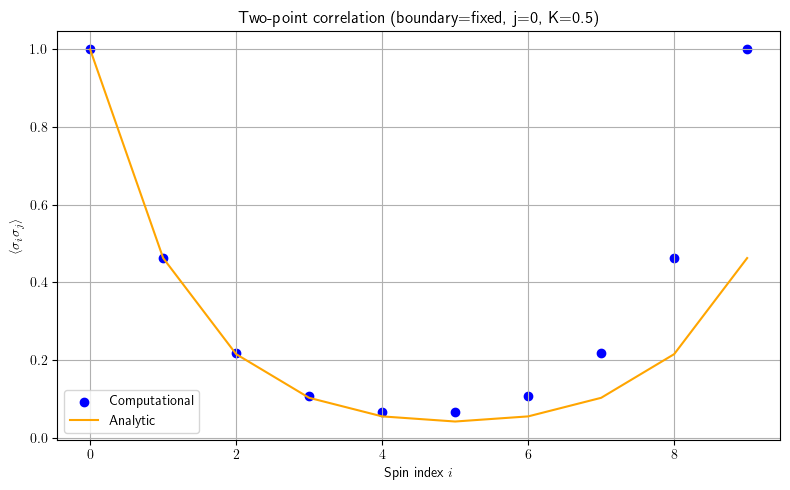

In [19]:
plot_two_point_correlation_v2(
    config_file="config_fixed_1_1.dat",
    K=0.5,
    boundary="fixed",
    left_spin=1,
    right_spin=1
)